In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
# === BLOCK 1: IMPORT NECESSARY LIBRARIES ===
# All libraries are the same.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# --- Preprocessing & Pipeline ---
from sklearn.preprocessing import StandardScaler, LabelEncoder # <-- ADDED LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline  # Use the imblearn pipeline
from imblearn.over_sampling import SMOTE

# --- Model Selection & Evaluation ---
from sklearn.model_selection import (
    # train_test_split is no longer needed for the final report
    StratifiedKFold, 
    GridSearchCV
)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Classifier Models ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


print("All libraries, including all models, imported successfully.")

# --- MODIFIED: File paths for your new data ---
TRAIN_FILE = '/kaggle/input/imcoh-epileptic-dataset/train_imcoh_features.csv'
TEST_FILE = '/kaggle/input/imcoh-epileptic-dataset/test_imcoh_features.csv'

# === BLOCK 2: LOAD AND PREPARE PRE-SPLIT DATA ===
# This block is MODIFIED to load your pre-split train and test files.

def load_pre_split_data(train_path, test_path):
    """
    Loads and prepares the pre-split train and test datasets.
    """
    print(f"\nLoading TRAINING data from {train_path}...")
    try:
        train_df = pd.read_csv(train_path)
        print(f"Loaded {len(train_df)} training subjects.")
        
        print(f"Loading TESTING data from {test_path}...")
        test_df = pd.read_csv(test_path)
        print(f"Loaded {len(test_df)} testing subjects.")
        
    except FileNotFoundError as e:
        print(f"ERROR: File not found. {e}")
        print("Please make sure 'train_imcoh_features.csv' and 'test_imcoh_features.csv' are in the correct path.")
        return None, None, None, None, None, None # <-- MODIFIED: Return None 6x

    # --- Prepare Training Data ---
    # The 'label' column (e.g., 'epileptic', 'normal') is our target y
    y_train_text = train_df['label']
    X_train = train_df.drop(columns=['subject_id', 'label'])
    
    # --- Prepare Testing Data ---
    y_test_text = test_df['label']
    X_test = test_df.drop(columns=['subject_id', 'label'])

    # --- NEW: Encode text labels to integers (0, 1) ---
    encoder = LabelEncoder()
    # Fit on the training labels to create the mapping
    y_train = encoder.fit_transform(y_train_text)
    # Use the same mapping to transform the test labels
    y_test = encoder.transform(y_test_text)
    
    # Get the original class names (e.g., ['epileptic', 'normal'])
    # This is still crucial for the final reports
    class_names = encoder.classes_
    print(f"\nTarget classes found and encoded: {list(zip(class_names, encoder.transform(class_names)))}")

    # --- NEW: Check for class imbalance in the training data ---
    print("\n--- Training Data Class Balance ---")
    # Get counts of the numeric labels (0, 1)
    class_counts_numeric = pd.Series(y_train).value_counts().sort_index()
    # Map index back to text names for a clear report
    class_counts_text = class_counts_numeric.copy()
    class_counts_text.index = class_counts_text.index.map(lambda i: class_names[i])
    print(class_counts_text)
    
    is_imbalanced = False
    if len(class_counts_numeric) == 2:
        minority_count = class_counts_numeric.min()
        majority_count = class_counts_numeric.max()
        # If minority is less than 70% of majority, we'll call it imbalanced
        if minority_count / majority_count < 0.7:
            is_imbalanced = True
            print("STATUS: Data is imbalanced. SMOTE will be applied.")
        else:
            print("STATUS: Data is reasonably balanced. SMOTE will NOT be applied.")
    # --- End of New Block ---


    # --- Handle Missing Values ---
    if X_train.isnull().values.any():
        print("\nMissing values found in training data. Filling with column mean...")
        # Fit on training data
        filler = X_train.mean()
        X_train = X_train.fillna(filler)
        # Transform test data with training means
        X_test = X_test.fillna(filler)
    else:
        print("\nNo missing values found.")
        
    print(f"Features (X_train) shape: {X_train.shape}")
    print(f"Target (y_train) shape: {y_train.shape}")
    print(f"Features (X_test) shape: {X_test.shape}")
    print(f"Target (y_test) shape: {y_test.shape}")
    
    # <-- MODIFIED: Return imbalance status
    return X_train, y_train, X_test, y_test, class_names, is_imbalanced

# === BLOCK 3: DEFINE MODEL SEARCH SPACE (PIPELINES & HYPERPARAMETERS) ===
# <-- MODIFIED: This function now accepts the imbalance status

def get_model_search_space(is_imbalanced):
    """
    Returns a dictionary of models and their hyperparameter grids.
    Each model is defined as a 'classifier' step for our pipeline.
    
    SMOTE is now added CONDITIONALLY.
    """
    
    # --- MODIFIED: Conditionally define base steps ---
    if is_imbalanced:
        print("\nBuilding pipelines WITH SMOTE...")
        base_steps = [
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(score_func=f_classif))
        ]
    else:
        print("\nBuilding pipelines WITHOUT SMOTE...")
        base_steps = [
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(score_func=f_classif))
        ]
    # --- End of Modified Block ---
    
    search_space = {
        
        'XGBoost': {
            'pipeline': Pipeline(base_steps + [('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))]),
            'params': {
                'selector__k': [50,55, 60,65, 70,75,80,90,100,120], 
                'classifier__learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1], 
                'classifier__max_depth': [1,2, 3,4], 
                'classifier__n_estimators': [80,90,95,100,105,110,120]
            }
        },
        
        'RandomForest': {
            'pipeline': Pipeline(base_steps + [('classifier', RandomForestClassifier(random_state=42))]),
            'params': {
                'selector__k': [80,90,95,100,105,110,120],
                'classifier__max_depth': [1,2, 3, 4,5], 
                'classifier__n_estimators': [20,25,30,35, 40]
            }
        },
        
        'SVM (RBF Kernel)': {
            'pipeline': Pipeline(base_steps + [('classifier', SVC(kernel='rbf', probability=True, random_state=42))]),
            'params': {
                'selector__k': [30,35, 40,45, 50,55,60,70,80,90,100], 
                'classifier__C': [0.15,0.2,0.25,0.3,0.35,0.4,0.45], 
                'classifier__gamma': [0.01,0.02,0.03,0.04,0.05, 0.06, 0.07]
            }
        },
        
        'DecisionTree': {
            'pipeline': Pipeline(base_steps + [('classifier', DecisionTreeClassifier(random_state=42))]),
            'params': {
                'selector__k': [40,45,55,50,60,65],
                'classifier__max_depth': [1,2,3], 
                'classifier__min_samples_leaf': [1, 2,3]
            }
        },
        
        'KNeighbors': {
            'pipeline': Pipeline(base_steps + [('classifier', KNeighborsClassifier())]),
            'params': {
                'selector__k': [40],
                'classifier__n_neighbors': [2] 
            }
        },
        
        'GaussianNB': {
            'pipeline': Pipeline(base_steps + [('classifier', GaussianNB())]),
            'params': {
                'selector__k': [20],
            }
        }
    }
    print("\nModel search space defined.")
    return search_space

# === BLOCK 4: RUN GridSearchCV FOR ALL MODELS ===
# This block is identical, but it will be called with X_train, y_train.

def run_all_grid_searches(search_space, X, y):
    """
    Runs GridSearchCV for every model in the search space and returns the results.
    """
    print("\nSetting up 5-Fold Stratified Cross-Validation (on TRAINING data)...")
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    for model_name, config in search_space.items():
        print(f"\n--- Running GridSearch for: {model_name} ---")
        
        grid_search = GridSearchCV(
            estimator=config['pipeline'], 
            param_grid=config['params'], 
            cv=cv_strategy, 
            scoring='accuracy',
            n_jobs=-1,  # Use all cores
            verbose=1,  # Show progress
            refit=True  # IMPORTANT: Refits the best model on ALL training data
        )
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # This will now fit on y_train which contains 0s and 1s
            grid_search.fit(X, y)
            
        # Store the results
        results.append({
            'model_name': model_name,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'best_estimator': grid_search.best_estimator_
        })
        
        print(f"--- Best CV Score for {model_name}: {grid_search.best_score_ * 100:.2f}% ---")
        
    return results

# === MAIN EXECUTION SCRIPT ===

# Execute data loading
# <-- MODIFIED: Get is_imbalanced status
X_train, y_train, X_test, y_test, class_names, is_imbalanced = load_pre_split_data(TRAIN_FILE, TEST_FILE)

if X_train is not None:
    
    # Execute model definition
    # <-- MODIFIED: Pass status to function
    search_space = get_model_search_space(is_imbalanced) 
    
    # MODIFIED: Run grid search ONLY on the training data
    all_results = run_all_grid_searches(search_space, X_train, y_train)

    # === BLOCK 5: SHOW SUMMARY OF ALL MODEL RESULTS ===
    # This block is identical.
    
    print("\n" + "="*40)
    print("--- OVERALL MODEL COMPARISON (from CV on Train Data) ---")
    # --- THIS IS THE CORRECTED LINE ---
    print("="*40 + "\n")
    
    # Sort results by score, descending
    all_results.sort(key=lambda x: x['best_score'], reverse=True)
    
    print("Printing full results for all tested models, from best to worst:\n")
    for result in all_results:
        print(f"Model: {result['model_name']}")
        print(f"  Best Mean CV Accuracy: {result['best_score'] * 100:.2f}%")
        print(f"  Best Hyperparameters: {result['best_params']}")
        print("-" * 30)

    # --- Print Summary DataFrame ---
    print("\n--- Summary DataFrame ---")
    results_df = pd.DataFrame(all_results, columns=['model_name', 'best_score', 'best_params'])
    results_df['best_score'] = (results_df['best_score'] * 100).round(2)
    
    results_df['best_params'] = results_df['best_params'].astype(str)
    
    print(results_df)


    # === BLOCK 6: ANALYZE THE SINGLE BEST MODEL ===
    # This block is identical, but uses X_train.columns
    
    best_overall_result = all_results[0] # The winner is the first item
    best_pipeline = best_overall_result['best_estimator']
    
    print(f"\n\n--- In-Depth Analysis of WINNING Model: {best_overall_result['model_name']} ---")
    print(f"Best Mean CV Accuracy: {best_overall_result['best_score'] * 100:.2f}%")
    print("Best Hyperparameters:")
    print(best_overall_result['best_params'])
    
    print("\n--- Feature Importance Analysis (from Best Model) ---")
    
    try:
        # Get the 'selector' and 'classifier' steps from the best pipeline
        selector = best_pipeline.named_steps['selector']
        
        # Check if the classifier has 'feature_importances_' (e.g., RF, XGB)
        if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
            classifier = best_pipeline.named_steps['classifier']
            feature_importances = classifier.feature_importances_
        # Check if it has 'coef_' (e.g., linear SVM)
        elif hasattr(best_pipeline.named_steps['classifier'], 'coef_'):
            # Use absolute value of coefficients
            feature_importances = np.abs(best_pipeline.named_steps['classifier'].coef_[0])
        else:
            print("This model type does not provide standard feature importances.")
            feature_importances = None

        if feature_importances is not None:
            # MODIFIED: Use X_train.columns
            all_feature_names = X_train.columns
            selected_mask = selector.get_support()
            selected_feature_names = all_feature_names[selected_mask]
            
            importance_df = pd.DataFrame({
                'Feature': selected_feature_names,
                'Importance': feature_importances
            }).sort_values(by='Importance', ascending=False)
            
            print(f"\nTop 10 most important features:")
            print(importance_df.head(10))

    except Exception as e:
        print(f"Could not compute feature importances: {e}")

    # === BLOCK 7: FINAL REPORT FOR BEST MODEL (on HELD-OUT TEST data) ===
    # This block is MODIFIED to use the X_test, y_test data directly.
    
    print(f"\n--- Final Model Performance on HELD-OUT TEST DATA (Winner: {best_overall_result['model_name']}) ---")
    
    # MODIFIED: No train_test_split! We use the loaded test data.
    # The 'best_pipeline' was already refit on the full X_train, y_train
    # by GridSearchCV (because refit=True)
    y_pred = best_pipeline.predict(X_test) # y_pred will be 0 or 1
    
    print(f"Classification Report (on {len(y_test)} test subjects):")
    # MODIFIED: Use the dynamic class_names. 
    # y_test is 0 or 1, but target_names maps 0->'epileptic', 1->'normal'
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print("Plotting Confusion Matrix for Best Model...")
    try:
        # MODIFIED: Use the dynamic class_names for labels
        cm = confusion_matrix(y_test, y_pred) 
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix on Test Data (Winner: {best_overall_result["model_name"]})')
        plt.savefig('confusion_matrix_test_data.png')
        print("Saved 'confusion_matrix_test_data.png'")
    except Exception as e:
        print(f"Could not save plot: {e}")

else:
    print("\nScript terminated because data could not be loaded.")



In [ ]:
import pandas as pd
import os

# --- Configuration ---

# <<< MODIFIED >>>
# UPDATE THIS PATH to the single folder containing all 8 feature CSVs
ROOT_INPUT_PATH = "/kaggle/input/epileptic-four-feature" 
# <<< END MODIFIED >>>

# This list defines the base *filenames* (with underscores)
# This part remains the same
feature_files = [
    'combined_power_features', # 210 features
    'wpli2_debiased_features', # 1050 features
    'perm_entropy_features',   # 21 features
    'hfd_features'             # 21 features
]

# <<< REMOVED >>>
# The FOLDER_MAP is no longer needed for a single-folder structure
# <<< END REMOVED >>>

# Define paths
output_dir = "/kaggle/working/master_dataset"
os.makedirs(output_dir, exist_ok=True)

# --- Main Merging Function ---

def merge_features_for_split(split_name):
    """
    Finds, loads, and merges all feature files for a given split (train or test).
    """
    print(f"\n--- Processing Split: {split_name} ---")
    
    master_df = None
    
    for base_name in feature_files:
        
        # --- MODIFIED PATH LOGIC ---
        file_name = f"{split_name}_{base_name}.csv"
        
        # Build the simplified, direct path to the file
        file_path = os.path.join(ROOT_INPUT_PATH, file_name)
        # --- END MODIFIED PATH LOGIC ---

        if not os.path.exists(file_path):
            print(f"  - ⚠️ WARNING: File not found, skipping: {file_path}")
            continue
            
        print(f"  - Loading {file_name}...")
        try:
            df = pd.read_csv(file_path)
            
            # Handle potential NaN values (e.g., from a failed HFD epoch)
            if df.isnull().values.any():
                print(f"    - Found NaN values in {file_name}. Filling with 0.")
                df = df.fillna(0) # Fill NaNs with 0
            
            # For the first file, initialize the master DataFrame
            if master_df is None:
                master_df = df
            else:
                # For subsequent files, merge on 'subject_id' and 'label'
                # Drop redundant 'label' column from the new df
                df_to_merge = df.drop(columns=['label'])
                master_df = pd.merge(master_df, df_to_merge, on='subject_id', how='inner')
                
        except Exception as e:
            print(f"  - ❌ ERROR loading or merging {file_name}: {e}")
            
    if master_df is not None:
        save_path = os.path.join(output_dir, f"{split_name}_MASTER_features.csv")
        master_df.to_csv(save_path, index=False)
        print(f"✅ Successfully saved {split_name} master file to {save_path}")
        print(f"    → Final Shape: {master_df.shape}")
    else:
        print(f"❌ No features were merged for {split_name}.")

# --- Run for both splits ---
merge_features_for_split('train')
merge_features_for_split('test')

print("\nAll features combined successfully.")



All libraries, including dimensionality reduction tools, imported successfully.

Loading TRAINING data from /kaggle/working/master_dataset/train_MASTER_features.csv...
Loaded 169 training subjects.
Loading TESTING data from /kaggle/working/master_dataset/test_MASTER_features.csv...
Loaded 43 testing subjects.

Target classes found: ['epileptic' 'normal']

No missing values found.
Features (X_train) shape: (169, 1302)
Features (X_test) shape: (43, 1302)

Model search space defined with PCA, Lasso, and 7 classifiers.

Setting up 5-Fold Stratified Cross-Validation (on TRAINING data)...

--- Running GridSearch for: RF_with_PCA ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Best CV Score for RF_with_PCA: 60.36% ---

--- Running GridSearch for: RF_with_Lasso ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Best CV Score for RF_with_Lasso: 69.86% ---

--- Running GridSearch for: SVM_with_PCA ---
Fitting 5 folds for each of 4 candidates, totalling 20 fit

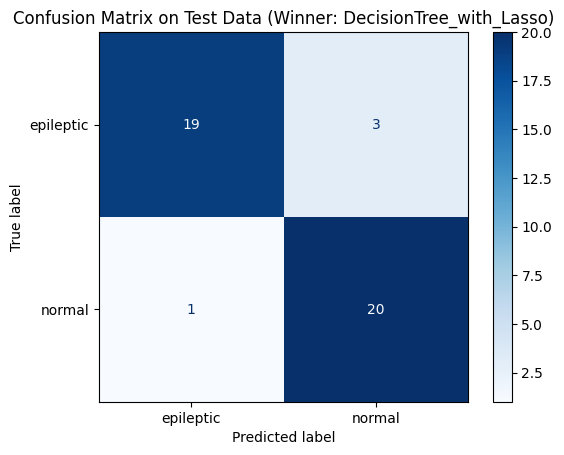

In [1]:
# === BLOCK 1: IMPORT NECESSARY LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# --- Preprocessing & Pipeline ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.pipeline import Pipeline # Use imblearn pipeline
# --- MODIFIED: Import PCA and Lasso ---
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression # Using LogisticRegression for Lasso

# --- Model Selection & Evaluation ---
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Classifier Models ---
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# --- NEW: Added DecisionTree and KNN ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

print("All libraries, including dimensionality reduction tools, imported successfully.")

# --- MODIFIED: File paths for your MASTER data ---
TRAIN_FILE = '/kaggle/working/master_dataset/train_MASTER_features.csv'
TEST_FILE = '/kaggle/working/master_dataset/test_MASTER_features.csv'

# === BLOCK 2: LOAD AND PREPARE PRE-SPLIT DATA ===
# This block is now simplified as we only load one file
# and we add the LabelEncoder

def load_pre_split_data(train_path, test_path):
    print(f"\nLoading TRAINING data from {train_path}...")
    try:
        train_df = pd.read_csv(train_path)
        print(f"Loaded {len(train_df)} training subjects.")
        
        print(f"Loading TESTING data from {test_path}...")
        test_df = pd.read_csv(test_path)
        print(f"Loaded {len(test_df)} testing subjects.")
        
    except FileNotFoundError as e:
        print(f"ERROR: File not found. {e}")
        print("Please run the '1. Combine Feature CSVs.py' script first.")
        return None, None, None, None, None

    # --- Prepare Training Data ---
    y_train_text = train_df['label']
    X_train = train_df.drop(columns=['subject_id', 'label'])
    
    # --- Prepare Testing Data ---
    y_test_text = test_df['label']
    X_test = test_df.drop(columns=['subject_id', 'label'])

    # --- Encode Labels ---
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train_text)
    y_test = encoder.transform(y_test_text)
    
    # Get the class names in the correct order (e.g., [epileptic, normal])
    class_names = encoder.classes_
    print(f"\nTarget classes found: {class_names}")

    # --- Handle Missing Values (e.g., from HFD failsafe) ---
    if X_train.isnull().values.any():
        print("\nMissing values (NaN) found. Filling with column mean...")
        filler = X_train.mean()
        X_train = X_train.fillna(filler)
        X_test = X_test.fillna(filler)
    else:
        print("\nNo missing values found.")
        
    print(f"Features (X_train) shape: {X_train.shape}") # (169, 1302)
    print(f"Features (X_test) shape: {X_test.shape}")   # (47, 1302)
    
    return X_train, y_train, X_test, y_test, class_names

# === BLOCK 3: DEFINE MODEL SEARCH SPACE (PIPELINES & HYPERPARAMETERS) ===
# This is the "Cure" for the Curse of Dimensionality.
# We will create different pipelines for each reduction method.

def get_model_search_space():
    """
    Returns a dictionary of models and their hyperparameter grids.
    Each pipeline now includes a dimensionality reduction step.
    """
    
    # --- We create two separate "base" pipelines ---
    
    # Recipe A: PCA (Feature Extraction)
    # This pipeline scales the data, then runs PCA to find the best components.
    pipeline_pca = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(random_state=42)),
        ('classifier', 'passthrough') # We will add the classifier later
    ])
    
    # Recipe B: Lasso (Feature Selection)
    # This pipeline scales the data, then uses Lasso to select the best features.
    pipeline_lasso = Pipeline([
        ('scaler', StandardScaler()),
        # We use LogisticRegression with 'l1' (Lasso) penalty for selection
        ('reducer', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42, max_iter=1000))),
        ('classifier', 'passthrough') # We will add the classifier later
    ])

    # --- Now we define the search space to test BOTH pipelines ---
    
    search_space = {
        
        # --- RandomForest ---
        'RF_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95], # Keep 95% of variance
                'classifier': [RandomForestClassifier(random_state=42)],
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [5, 10]
            }
        },
        'RF_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0], # Tune Lasso penalty
                'classifier': [RandomForestClassifier(random_state=42)],
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [5, 10]
            }
        },
        
        # --- SVM ---
        'SVM_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95],
                'classifier': [SVC(kernel='rbf', probability=True, random_state=42)],
                'classifier__C': [1, 10],
                'classifier__gamma': [0.01, 0.1]
            }
        },
        'SVM_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0],
                'classifier': [SVC(kernel='rbf', probability=True, random_state=42)],
                'classifier__C': [1, 10],
                'classifier__gamma': [0.01, 0.1]
            }
        },

        # --- Logistic Regression ---
        'LogReg_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95],
                'classifier': [LogisticRegression(penalty='l2', solver='liblinear', random_state=42)],
                'classifier__C': [0.1, 1.0, 10] # 'l2' (Ridge) classifier
            }
        },
        'LogReg_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0],
                'classifier': [LogisticRegression(penalty='l2', solver='liblinear', random_state=42)],
                'classifier__C': [0.1, 1.0, 10]
            }
        },

        # --- Gradient Boosting ---
        'GradBoost_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95],
                'classifier': [GradientBoostingClassifier(random_state=42)],
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1]
            }
        },
        'GradBoost_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0],
                'classifier': [GradientBoostingClassifier(random_state=42)],
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1]
            }
        },

        # --- XGBoost ---
        'XGB_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95],
                'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1]
            }
        },
        'XGB_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0],
                'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1]
            }
        },
        
        # --- NEW: K-Nearest Neighbors ---
        'KNN_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95],
                'classifier': [KNeighborsClassifier()],
                'classifier__n_neighbors': [3, 5, 7, 9] # Test different K values
            }
        },
        'KNN_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0],
                'classifier': [KNeighborsClassifier()],
                'classifier__n_neighbors': [3, 5, 7, 9]
            }
        },

        # --- NEW: Decision Tree ---
        'DecisionTree_with_PCA': {
            'pipeline': pipeline_pca,
            'params': {
                'reducer__n_components': [0.95],
                'classifier': [DecisionTreeClassifier(random_state=42)],
                'classifier__max_depth': [3, 5, 10],
                'classifier__min_samples_leaf': [1, 5, 10]
            }
        },
        'DecisionTree_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                'reducer__estimator__C': [0.1, 1.0],
                'classifier': [DecisionTreeClassifier(random_state=42)],
                'classifier__max_depth': [3, 5, 10],
                'classifier__min_samples_leaf': [1, 5, 10]
            }
        },
    }
    
    # --- MODIFIED: Updated count from 5 to 7 ---
    print("\nModel search space defined with PCA, Lasso, and 7 classifiers.")
    return search_space

# === BLOCK 4: RUN GridSearchCV FOR ALL MODELS ===
# This block is now more powerful. It will test all 14 pipeline configs.

def run_all_grid_searches(search_space, X, y):
    print("\nSetting up 5-Fold Stratified Cross-Validation (on TRAINING data)...")
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    for model_name, config in search_space.items():
        print(f"\n--- Running GridSearch for: {model_name} ---")
        
        grid_search = GridSearchCV(
            estimator=config['pipeline'], 
            param_grid=config['params'], 
            cv=cv_strategy, 
            scoring='accuracy',
            n_jobs=-1,  # Use all cores
            verbose=1,  # Show progress
            refit=True
        )
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search.fit(X, y)
            
        results.append({
            'model_name': model_name,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'best_estimator': grid_search.best_estimator_
        })
        
        print(f"--- Best CV Score for {model_name}: {grid_search.best_score_ * 100:.2f}% ---")
        
    return results

# === MAIN EXECUTION SCRIPT ===

# Execute data loading
X_train, y_train, X_test, y_test, class_names = load_pre_split_data(TRAIN_FILE, TEST_FILE)

if X_train is not None:
    
    search_space = get_model_search_space()
    
    all_results = run_all_grid_searches(search_space, X_train, y_train)

    # === BLOCK 5: SHOW SUMMARY OF ALL MODEL RESULTS ===
    
    print("\n" + "="*40)
    print("--- OVERALL MODEL COMPARISON (with Dimensionality Reduction) ---")
    print("="*40 + "\n")
    
    all_results.sort(key=lambda x: x['best_score'], reverse=True)
    
    print("Printing full results for all tested models, from best to worst:\n")
    for result in all_results:
        print(f"Model: {result['model_name']}")
        print(f"  Best Mean CV Accuracy: {result['best_score'] * 100:.2f}%")
        print(f"  Best Hyperparameters: {result['best_params']}")
        print("-" * 30)

    # --- Print Summary DataFrame ---
    print("\n--- Summary DataFrame ---")
    results_df = pd.DataFrame(all_results, columns=['model_name', 'best_score'])
    results_df['best_score'] = (results_df['best_score'] * 100).round(2)
    print(results_df)

    # === BLOCK 6: ANALYZE THE SINGLE BEST MODEL ===
    
    best_overall_result = all_results[0]
    best_pipeline = best_overall_result['best_estimator']
    
    print(f"\n\n--- In-Depth Analysis of WINNING Model: {best_overall_result['model_name']} ---")
    print(f"Best Mean CV Accuracy: {best_overall_result['best_score'] * 100:.2f}%")
    
    # --- Feature Importance Analysis ---
    # This is more complex now, we check if the winner was Lasso or PCA
    
    best_reducer = best_pipeline.named_steps['reducer']
    
    if isinstance(best_reducer, SelectFromModel):
        print("\n--- Feature Importance Analysis (from Lasso) ---")
        try:
            selected_mask = best_reducer.get_support()
            selected_feature_names = X_train.columns[selected_mask]
            print(f"Lasso selected {len(selected_feature_names)} features out of {len(X_train.columns)}:")
            # Print top 20 selected features
            print(selected_feature_names.to_list()[:20])
        except Exception as e:
            print(f"Could not compute Lasso feature importances: {e}")
            
    elif isinstance(best_reducer, PCA):
        print("\n--- Feature Analysis (from PCA) ---")
        print(f"PCA reduced {len(X_train.columns)} features to {best_reducer.n_components_} components.")
        print(f"These components explain {np.sum(best_reducer.explained_variance_ratio_) * 100:.2f}% of the variance.")
        # Note: We can't easily show feature names for PCA as they are combinations
    
    # === BLOCK 7: FINAL REPORT FOR BEST MODEL (on HELD-OUT TEST data) ===
    
    print(f"\n--- Final Model Performance on HELD-OUT TEST DATA (Winner: {best_overall_result['model_name']}) ---")
    
    y_pred = best_pipeline.predict(X_test)
    
    print(f"Classification Report (on {len(y_test)} test subjects):")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print("Plotting Confusion Matrix for Best Model...")
    try:
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix on Test Data (Winner: {best_overall_result["model_name"]})')
        plt.savefig('confusion_matrix_test_data.png')
        print("Saved 'confusion_matrix_test_data.png'")
    except Exception as e:
        print(f"Could not save plot: {e}")

else:
    print("\nScript terminated because data could not be loaded.")



All libraries, including dimensionality reduction tools, imported successfully.

Loading TRAINING data from /kaggle/working/master_dataset/train_MASTER_features.csv...
Loaded 169 training subjects.
Loading TESTING data from /kaggle/working/master_dataset/test_MASTER_features.csv...
Loaded 43 testing subjects.

Target classes found: ['epileptic' 'normal']

No missing values found.
Features (X_train) shape: (169, 1302)
Features (X_test) shape: (43, 1302)

Model search space defined. Focusing on the Top 2 winning pipelines (Lasso + DT, Lasso + XGB).

Setting up 5-Fold Stratified Cross-Validation (on TRAINING data)...

--- Running GridSearch for: DecisionTree_with_Lasso ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits
--- Best CV Score for DecisionTree_with_Lasso: 82.23% ---

--- Running GridSearch for: XGB_with_Lasso ---
Fitting 5 folds for each of 144 candidates, totalling 720 fits
--- Best CV Score for XGB_with_Lasso: 73.99% ---

--- OVERALL MODEL COMPARISON (Fine-Tuni

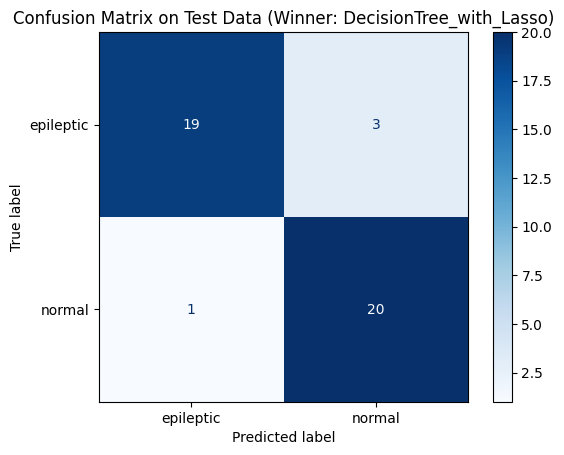

In [2]:
# === BLOCK 1: IMPORT NECESSARY LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# --- Preprocessing & Pipeline ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.pipeline import Pipeline # Use imblearn pipeline
# --- MODIFIED: Import PCA and Lasso ---
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression # Using LogisticRegression for Lasso

# --- Model Selection & Evaluation ---
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Classifier Models ---
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# --- NEW: Added DecisionTree and KNN ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

print("All libraries, including dimensionality reduction tools, imported successfully.")

# --- MODIFIED: File paths for your MASTER data ---
TRAIN_FILE = '/kaggle/working/master_dataset/train_MASTER_features.csv'
TEST_FILE = '/kaggle/working/master_dataset/test_MASTER_features.csv'

# === BLOCK 2: LOAD AND PREPARE PRE-SPLIT DATA ===
# This block is now simplified as we only load one file
# and we add the LabelEncoder

def load_pre_split_data(train_path, test_path):
    print(f"\nLoading TRAINING data from {train_path}...")
    try:
        train_df = pd.read_csv(train_path)
        print(f"Loaded {len(train_df)} training subjects.")
        
        print(f"Loading TESTING data from {test_path}...")
        test_df = pd.read_csv(test_path)
        print(f"Loaded {len(test_df)} testing subjects.")
        
    except FileNotFoundError as e:
        print(f"ERROR: File not found. {e}")
        print("Please run the '1. Combine Feature CSVs.py' script first.")
        return None, None, None, None, None

    # --- Prepare Training Data ---
    y_train_text = train_df['label']
    X_train = train_df.drop(columns=['subject_id', 'label'])
    
    # --- Prepare Testing Data ---
    y_test_text = test_df['label']
    X_test = test_df.drop(columns=['subject_id', 'label'])

    # --- Encode Labels ---
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train_text)
    y_test = encoder.transform(y_test_text)
    
    # Get the class names in the correct order (e.g., [epileptic, normal])
    class_names = encoder.classes_
    print(f"\nTarget classes found: {class_names}")

    # --- Handle Missing Values (e.g., from HFD failsafe) ---
    if X_train.isnull().values.any():
        print("\nMissing values (NaN) found. Filling with column mean...")
        filler = X_train.mean()
        X_train = X_train.fillna(filler)
        X_test = X_test.fillna(filler)
    else:
        print("\nNo missing values found.")
        
    print(f"Features (X_train) shape: {X_train.shape}") # (169, 1302)
    print(f"Features (X_test) shape: {X_test.shape}")   # (47, 1302)
    
    return X_train, y_train, X_test, y_test, class_names

# === BLOCK 3: DEFINE MODEL SEARCH SPACE (PIPELINES & HYPERPARAMETERS) ===
# This is the "Cure" for the Curse of Dimensionality.
# We will create different pipelines for each reduction method.

def get_model_search_space():
    """
    Returns a dictionary of models and their hyperparameter grids.
    Each pipeline now includes a dimensionality reduction step.
    """
    
    # --- We only need the Lasso-based pipeline, as it won the contest ---
    
    # Recipe B: Lasso (Feature Selection)
    # This pipeline scales the data, then uses Lasso to select the best features.
    pipeline_lasso = Pipeline([
        ('scaler', StandardScaler()),
        # We use LogisticRegression with 'l1' (Lasso) penalty for selection
        ('reducer', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=2000))),
        ('classifier', 'passthrough') # We will add the classifier later
    ])

    # --- Now we define the FOCUSED search space to tune the WINNERS ---
    
    search_space = {
        
        # --- The Champion: DecisionTree_with_Lasso ---
        'DecisionTree_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                # --- WIDER SEARCH ---
                # Tune the Lasso selector: C=0.1 was the winner
                'reducer__estimator__C': [0.05, 0.1, 0.15, 0.2], 
                'classifier': [DecisionTreeClassifier(random_state=42)],
                # Tune the Tree: max_depth=3, min_samples_leaf=10 were winners
                'classifier__criterion': ['gini', 'entropy'],
                'classifier__max_depth': [3, 4, 5, 6],
                'classifier__min_samples_leaf': [5, 10, 15, 20]
                # --- END WIDER SEARCH ---
            }
        },
        
        # --- The Runner-Up: XGB_with_Lasso ---
        'XGB_with_Lasso': {
            'pipeline': pipeline_lasso,
            'params': {
                # --- WIDER SEARCH ---
                # Tune the Lasso selector: C=1.0 was the winner
                'reducer__estimator__C': [0.1, 0.5, 1.0, 1.5],
                'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],
                # Tune the Model: lr=0.1, n_est=200 were winners
                'classifier__n_estimators': [150, 200, 250, 300],
                'classifier__learning_rate': [0.05, 0.1, 0.15],
                'classifier__max_depth': [3, 4, 5] # This wasn't tuned before!
                # --- END WIDER SEARCH ---
            }
        },
    }
    
    # --- MODIFIED: Updated text ---
    print("\nModel search space defined. Focusing on the Top 2 winning pipelines (Lasso + DT, Lasso + XGB).")
    return search_space

# === BLOCK 4: RUN GridSearchCV FOR ALL MODELS ===
# This block will now run a deeper search on only the 2 best models.

def run_all_grid_searches(search_space, X, y):
    print("\nSetting up 5-Fold Stratified Cross-Validation (on TRAINING data)...")
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    for model_name, config in search_space.items():
        print(f"\n--- Running GridSearch for: {model_name} ---")
        
        grid_search = GridSearchCV(
            estimator=config['pipeline'], 
            param_grid=config['params'], 
            cv=cv_strategy, 
            scoring='accuracy',
            n_jobs=-1,  # Use all cores
            verbose=1,  # Show progress
            refit=True
        )
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search.fit(X, y)
            
        results.append({
            'model_name': model_name,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'best_estimator': grid_search.best_estimator_
        })
        
        print(f"--- Best CV Score for {model_name}: {grid_search.best_score_ * 100:.2f}% ---")
        
    return results

# === MAIN EXECUTION SCRIPT ===

# Execute data loading
X_train, y_train, X_test, y_test, class_names = load_pre_split_data(TRAIN_FILE, TEST_FILE)

if X_train is not None:
    
    search_space = get_model_search_space()
    
    all_results = run_all_grid_searches(search_space, X_train, y_train)

    # === BLOCK 5: SHOW SUMMARY OF ALL MODEL RESULTS ===
    
    print("\n" + "="*40)
    print("--- OVERALL MODEL COMPARISON (Fine-Tuning Round) ---")
    print("="*40 + "\n")
    
    all_results.sort(key=lambda x: x['best_score'], reverse=True)
    
    print("Printing full results for all tested models, from best to worst:\n")
    for result in all_results:
        print(f"Model: {result['model_name']}")
        print(f"  Best Mean CV Accuracy: {result['best_score'] * 100:.2f}%")
        print(f"  Best Hyperparameters: {result['best_params']}")
        print("-" * 30)

    # --- Print Summary DataFrame ---
    print("\n--- Summary DataFrame ---")
    results_df = pd.DataFrame(all_results, columns=['model_name', 'best_score'])
    results_df['best_score'] = (results_df['best_score'] * 100).round(2)
    print(results_df)

    # === BLOCK 6: ANALYZE THE SINGLE BEST MODEL ===
    
    best_overall_result = all_results[0]
    best_pipeline = best_overall_result['best_estimator']
    
    print(f"\n\n--- In-Depth Analysis of WINNING Model: {best_overall_result['model_name']} ---")
    print(f"Best Mean CV Accuracy: {best_overall_result['best_score'] * 100:.2f}%")
    
    # --- Feature Importance Analysis ---
    # This is more complex now, we check if the winner was Lasso or PCA
    
    best_reducer = best_pipeline.named_steps['reducer']
    
    if isinstance(best_reducer, SelectFromModel):
        print("\n--- Feature Importance Analysis (from Lasso) ---")
        try:
            selected_mask = best_reducer.get_support()
            selected_feature_names = X_train.columns[selected_mask]
            print(f"Lasso selected {len(selected_feature_names)} features out of {len(X_train.columns)}:")
            # Print top 20 selected features
            print(selected_feature_names.to_list()[:20])
        except Exception as e:
            print(f"Could not compute Lasso feature importances: {e}")
            
    elif isinstance(best_reducer, PCA):
        print("\n--- Feature Analysis (from PCA) ---")
        print(f"PCA reduced {len(X_train.columns)} features to {best_reducer.n_components_} components.")
        print(f"These components explain {np.sum(best_reducer.explained_variance_ratio_) * 100:.2f}% of the variance.")
        # Note: We can't easily show feature names for PCA as they are combinations
    
    # === BLOCK 7: FINAL REPORT FOR BEST MODEL (on HELD-OUT TEST data) ===
    
    print(f"\n--- Final Model Performance on HELD-OUT TEST DATA (Winner: {best_overall_result['model_name']}) ---")
    
    y_pred = best_pipeline.predict(X_test)
    
    print(f"Classification Report (on {len(y_test)} test subjects):")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print("Plotting Confusion Matrix for Best Model...")
    try:
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix on Test Data (Winner: {best_overall_result["model_name"]})')
        plt.savefig('confusion_matrix_test_data.png')
        print("Saved 'confusion_matrix_test_data.png'")
    except Exception as e:
        print(f"Could not save plot: {e}")

else:
    print("\nScript terminated because data could not be loaded.")

